In [14]:
from transformers import pipeline
from utils import *

In [9]:
# More models in the model hub.
checkpoint = "google/owlvit-base-patch32"

detector = pipeline(model=checkpoint, task="zero-shot-object-detection")


from transformers import CLIPProcessor, CLIPModel
import torch

# define processor and model
model_id = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)

# move model to device if possible
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

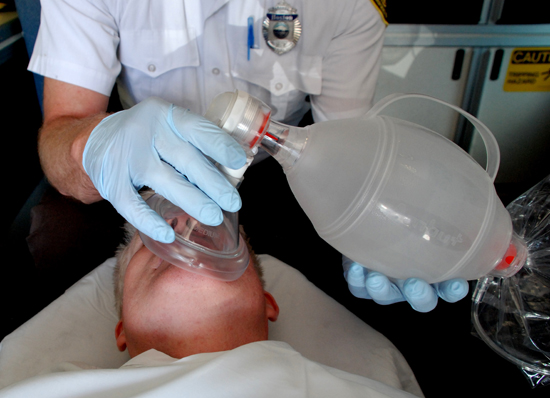

In [15]:
import skimage
import numpy as np
from PIL import Image
import cv2

image = cv2.imread('./images/resp - assist ventilation - bvm via mask/assist_bvm_1.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
# image = skimage.data.astronaut()
image = Image.fromarray(np.uint8(image)).convert("RGB")

image

In [11]:
# OpenAI Clip model
inputs = processor(text=["ECG monitor","a photo of a hand"], images=image, return_tensors="pt", padding=True)
inputs.to(device)
outputs = model(**inputs)

logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

print(torch.argmax(probs))

tensor(0, device='cuda:0')


In [18]:

protocol = "respiratory_distress_protocol"

labels = generate_labels(protocol)

predictions = detector(
    image,
    candidate_labels=labels,
)
predictions

[{'score': 0.15107202529907227,
  'label': 'Attaching nebulizer',
  'box': {'xmin': 251, 'ymin': 102, 'xmax': 522, 'ymax': 293}},
 {'score': 0.14744992554187775,
  'label': 'Attaching nebulizer',
  'box': {'xmin': 74, 'ymin': 95, 'xmax': 507, 'ymax': 288}},
 {'score': 0.1302918791770935,
  'label': 'Nebulizer mask',
  'box': {'xmin': 251, 'ymin': 102, 'xmax': 522, 'ymax': 293}}]

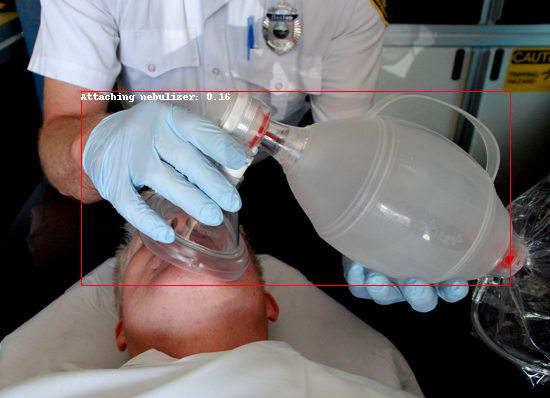

In [17]:
from PIL import ImageDraw

draw = ImageDraw.Draw(image)

for prediction in predictions:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]

    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{label}: {round(score,2)}", fill="white")
    
    break

image
